# Playing Tennis with DDPG

In this notebook I will solve the Unity ML [Tennis Environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) using [Deep Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) (DDPG). See the [README](https://github.com/bobflagg/Collaboration-and-Competition/blob/master/README.md) for instructions on how to setup your environment to run the code here.

In the [Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

The task is episodic, and in order to solve the environment, your agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single **score** for each episode.

The environment is considered solved, when the average (over 100 episodes) of those **scores** is at least +0.5.

## Background

The [Unity ML Reacher](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) is a *sequential decision making problem*, in which an agent interacts with an environment over discrete time steps and tries to find a policy to maximize the expected discounted return:
$$G_t = \sum_{\tau=t}^{\infty}\gamma^{\tau-t}R_\tau,$$
where $\gamma\in [0, 1]$ is a discount factor that trades-off the importance of immediate and future rewards. See [Sutton and Barto](http://incompleteideas.net/book/the-book.html) for a general discussion of this sort of problem.

In this notebook I'll focus on policy-based methods, which try to directly find an optimal policy, $\pi^*$, that an agent can use to decide what actions to take.  The particular algorithm, 
[Deep Deterministic Policy Gradient](http://proceedings.mlr.press/v32/silver14.pdf) (DDPG), is motivated by an important connection between the action selected by an optimal policy and the ***optimal action-value function***:
	$$Q^*(s, a) =  \max_{\pi}Q^{\pi}(s,a).$$
Namely, if you know the optimal action-value function, then in any given state, $s$, an optimal action can be found by solving
	 $$\pi^*(s) = \arg\max_a Q^*(s,a).$$
DDPG concurrently learns an approximator to $Q^*(s,a)$ and an approximator to $\pi^*(s)$, and it does so in a way which is specifically adapted for environments with continuous action spaces. 

### Learning $Q^*(s,a)$

The starting point for approximating $Q^*(s, a)$  is the **Bellman Equation**:
$$Q^{*}(s,a) = \mathbb{E}\big[R_{t+1}+\gamma\cdot\max_{a'}Q^{*}(S_{t+1},a')| S_t = s, A_t=a\big].$$
Suppose we are approximating $Q^*(s, a)$ with a neural network, $Q_\phi(s,a)$, and we have collected a set $\mathcal{D}$ of
transitions $(s, a, r, s', d)$, then the **mean-squared Bellman error** (MSBE)
		$$L(\phi, \mathcal{D}) = \mathbb{E}_{\mathcal{D}}\big[\big(Q_\phi(s,a)-(r+\gamma\cdot(1-d)\max_{a'}Q_\phi(s',a'))\big)^2\big]$$
tells us roughly how closely $Q_{\phi}$ comes to satisfying the Bellman equation and so can serve as the loss function in tuning $\phi$.

### Learning $\pi^*(s)$

Learning the optimal policy is pretty simple: we want to learn a deterministic policy $\pi^*(s)$ which gives the action that maximizes $Q^*(s, a)$.  This suggests using the loss function
    $$L(\theta, \mathcal{D}) = -\mathbb{E}_{\mathcal{D}}\big[Q_\phi(s,\pi_\theta(s))\big]$$
to tune the parameters, $\theta$, for a neural network, $\pi_\theta(s)$ approximating $\pi^*(s)$.


## Deep Deterministic Policy Gradient for Unity ML Tennis


### The Actor Network

In [1]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from utilities import hidden_init

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc_units=256):
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.bn1 = nn.BatchNorm1d(fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.bn1(self.fc1(state)))
        return F.tanh(self.fc2(x))

### The Critic Network

In [2]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bns1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        xs = F.leaky_relu(self.bns1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

### The Agent

To get DDPG to learn in a multi-agent environment I had to separate updating network parameters from adding samples to the replay buffer so that I could interleave these two steps in an appropriate proportion.

In [3]:
from collections import namedtuple, deque
import copy
import numpy as np
import torch.optim as optim
import random
from utilities import OUNoise, ReplayBuffer

BUFFER_SIZE = int(1e5)
BATCH_SIZE = 128
GAMMA = 0.99
TAU = 1e-3
LR_ACTOR = 1e-4
LR_CRITIC = 1e-3
WEIGHT_DECAY = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        #self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, random_seed)

    def act(self, state, add_noise=True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad(): action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise: action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def add(self, state, action, reward, next_state, done):
        # Save experience / reward
        self.memory.add_ddpg(state, action, reward, next_state, done)

    def update(self):
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)   
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

## The Environment

In [4]:
from unityagents import UnityEnvironment

env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [5]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [6]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### Training

By separating the updating of network parameters from adding samples to the replay buffer I can interleave these two steps in an appropriate proportion. The hyperparameters UPDATE_EVERY and N_UPDATES determine the proportion: the networks are updated N_UPDATES times after every UPDATE_EVERY timesteps.

In [7]:
def ddpg(env, agent, n_episodes=150, max_t=925, print_every=100):
    best_average_score = 0.0
    scores_deque = deque(maxlen=print_every)
    scores = []
    averaged_scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(2)
        for t in range(max_t):
            actions = [agent.act(np.expand_dims(states[i], axis=0)) for i in [0, 1]]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            one_done = False
            score += rewards
            for i in [0, 1]:
                state, action, reward, next_state, done = states[i], actions[i], rewards[i], next_states[i], dones[i]
                agent.add(state, action, reward, next_state, done)
                if done: one_done = True
            if t % UPDATE_EVERY == 0:
                for j in range(N_UPDATES): agent.update()
            states = next_states
            if one_done: break 
        score = np.max(score)
        scores_deque.append(score)
        scores.append(score)
        if i_episode >= 100:
            data = np.array(scores[i_episode - 100:i_episode])
            averaged_scores.append(np.mean(data))
        else: averaged_scores.append(0.0)
            
        average_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
        if average_score > best_average_score and i_episode > 100:
            best_average_score = average_score
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    return scores, averaged_scores

In [10]:
%%time
UPDATE_EVERY = 10
N_UPDATES = 30
n_episodes=1200
max_t=1000
agent = Agent(state_size=state_size, action_size=action_size, random_seed=6543) 
# 7654
scores, averaged_scores = ddpg(env, agent, n_episodes=n_episodes, max_t=max_t)



Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.02
Episode 300	Average Score: 0.06
Episode 400	Average Score: 0.18
Episode 500	Average Score: 0.49
Episode 600	Average Score: 0.57
Episode 700	Average Score: 0.58
Episode 800	Average Score: 0.74
Episode 900	Average Score: 0.79
Episode 1000	Average Score: 0.53
Episode 1100	Average Score: 0.65
Episode 1200	Average Score: 0.65
CPU times: user 4h 53min 16s, sys: 52min 56s, total: 5h 46min 13s
Wall time: 4h 3min 8s


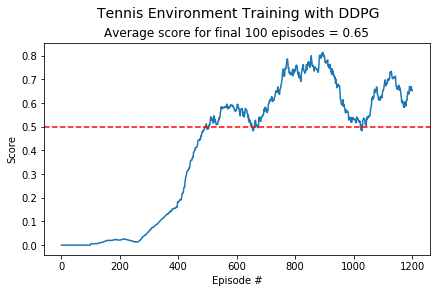

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14);

In [8]:
%%time
UPDATE_EVERY = 10
N_UPDATES = 30
n_episodes=1200
max_t=1000
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7654) 
scores, averaged_scores = ddpg(env, agent, n_episodes=n_episodes, max_t=max_t)


Episode 100	Average Score: 0.01
Episode 200	Average Score: 0.00
Episode 300	Average Score: 0.07
Episode 400	Average Score: 0.12
Episode 500	Average Score: 0.21
Episode 600	Average Score: 0.24
Episode 700	Average Score: 0.36
Episode 800	Average Score: 0.56
Episode 900	Average Score: 0.65
Episode 1000	Average Score: 0.67
Episode 1100	Average Score: 0.58
Episode 1200	Average Score: 0.56
CPU times: user 4h 4min 39s, sys: 47min 32s, total: 4h 52min 11s
Wall time: 3h 26min 11s


After 1,500 episodes the average score is 0.68 which is good enough to solve this task!  Below I show a plot of the scores for the entire training run.

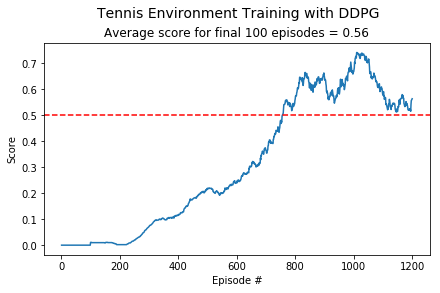

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14);




## Watch Smart Agents Play!

In [ ]:
agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

for i in range(1, 6):
    env_info = env.reset(train_mode=False)[brain_name]  
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    while True:
        actions = np.array([agent.act(np.expand_dims(states[i], axis=0)) for i in [0, 1]])
        actions = np.reshape(actions, (num_agents, action_size))
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            break
    print('Score (max over agents) from episode %d: %0.2f' % (i, np.max(scores)))